In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Load the dataset
# review_csv_path = 'yelp.csv'
df_rev = pd.read_csv('yelp.csv')

In [3]:
# Data preprocessing
df_rev = df_rev.dropna()
df_rev['binary_rating'] = np.where(df_rev['stars'] > 3, 1, 0)

In [4]:
# Balancing the dataset
positive = df_rev[df_rev['binary_rating'] == 1]
negative = df_rev[df_rev['binary_rating'] == 0]
max_count = min(len(positive), len(negative))
balanced_df = pd.concat([positive.sample(n=max_count), negative.sample(n=max_count)])
balanced_df = balanced_df.sample(frac=1, random_state=42).reset_index(drop=True)

In [5]:
# Splitting data
train_data, test_data, train_labels, test_labels = train_test_split(
    balanced_df['text'], balanced_df['binary_rating'], test_size=0.2, random_state=42
)

In [6]:
# Tokenizing and padding
tokenizer = Tokenizer(num_words=5000, oov_token='<OOV>')   
tokenizer.fit_on_texts(train_data)
train_sequences = tokenizer.texts_to_sequences(train_data)
train_padded = pad_sequences(train_sequences, maxlen=300, padding='post', truncating='post')  

test_sequences = tokenizer.texts_to_sequences(test_data)
test_padded = pad_sequences(test_sequences, maxlen=300, padding='post', truncating='post')

In [7]:
import pickle

# Save the tokenizer
with open('tokenizer2.pkl', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [8]:
# Building the LSTM model
model = Sequential([
    Embedding(input_dim=5001, output_dim=128, input_length=300),
    Bidirectional(LSTM(128, dropout=0.3, recurrent_dropout=0.3)),
    Dropout(0.4),
    Dense(100, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

C:\Users\Rana Comuter\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [9]:
# Compile model
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

In [17]:
# Train model
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
history = model.fit(train_padded, train_labels, epochs=15, validation_split=0.2, batch_size=32, callbacks=[early_stop])

Epoch 1/15
126/126 ━━━━━━━━━━━━━━━━━━━━ 140s 1s/step - accuracy: 0.8323 - loss: 0.4100 - val_accuracy: 0.7062 - val_loss: 0.6137
Epoch 2/15
126/126 ━━━━━━━━━━━━━━━━━━━━ 152s 1s/step - accuracy: 0.8804 - loss: 0.3190 - val_accuracy: 0.7181 - val_loss: 0.6599
Epoch 3/15
126/126 ━━━━━━━━━━━━━━━━━━━━ 199s 1s/step - accuracy: 0.8959 - loss: 0.2690 - val_accuracy: 0.7131 - val_loss: 0.7049
Epoch 4/15
126/126 ━━━━━━━━━━━━━━━━━━━━ 196s 1s/step - accuracy: 0.9175 - loss: 0.2175 - val_accuracy: 0.6942 - val_loss: 0.7993


In [18]:
# Evaluate model
loss, accuracy = model.evaluate(test_padded, test_labels)
print(f"Test Accuracy: {accuracy}")

40/40 ━━━━━━━━━━━━━━━━━━━━ 12s 287ms/step - accuracy: 0.7253 - loss: 0.6060
Test Accuracy: 0.737051784992218


In [19]:
# Classification report
test_predictions = model.predict(test_padded)
binary_predictions = (test_predictions > 0.5).astype(int)
print(classification_report(test_labels, binary_predictions))

40/40 ━━━━━━━━━━━━━━━━━━━━ 10s 226ms/step
              precision    recall  f1-score   support

           0       0.75      0.72      0.73       631
           1       0.73      0.75      0.74       624

    accuracy                           0.74      1255
   macro avg       0.74      0.74      0.74      1255
weighted avg       0.74      0.74      0.74      1255



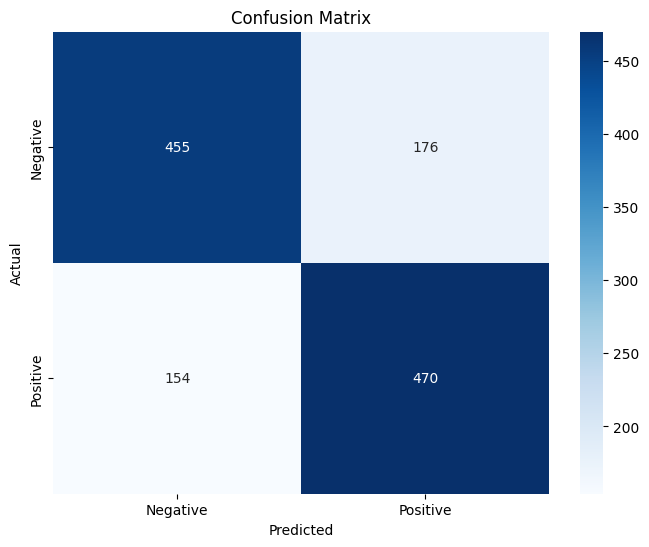

In [20]:
# Confusion matrix
confusion_mtx = confusion_matrix(test_labels, binary_predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mtx, annot=True, fmt="d", cmap="Blues", xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [21]:
# Save the model as a .h5 file
model.save('lstm_sentiment_model.h5')